<a href="https://colab.research.google.com/github/Max452/CarND-LaneLines-P1/blob/master/Copie_de_dogvscat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [3]:
!kaggle datasets list 

ref                                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/muratkokludataset/acoustic-extinguisher-fire-dataset                  Acoustic Extinguisher Fire Dataset               621KB  2022-04-02 22:59:36            934        643  0.9375           
datasets/muratkokludataset/rice-image-dataset                                  Rice Image Dataset                               219MB  2022-04-03 02:12:00           1022        592  0.875            
datasets/mdmahmudulhasansuzan/students-adaptability-level-in-online-education  Students Adaptability Level in Online Education    6KB  2022-04-16 04:46:28           3649         87  1.0              


In [6]:
! kaggle competitions list

ref                                                       deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
mpetitions/contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         39           False  
mpetitions/gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        136           False  
mpetitions/store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        909           False  
mpetitions/tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        163           False  
mpetitions/digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2113           False  
mpetitions/titanic                                     

In [5]:
!kaggle competitions download -c dogs-vs-cats

 98% 792M/812M [00:04<00:00, 205MB/s]
100% 812M/812M [00:04<00:00, 192MB/s]


In [6]:
!unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [7]:
!rm dogs-vs-cats.zip sampleSubmission.csv

In [8]:
!unzip -qq  train.zip

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, RandomFlip, RandomRotation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
from sklearn.metrics import ConfusionMatrixDisplay
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [10]:
data_home="data/dogs-vs-cats"

In [11]:
if os.path.isdir(data_home) is True:
  shutil.rmtree(data_home)

In [12]:
if os.path.isdir(data_home) is False:
  os.makedirs(os.path.join(data_home, 'train/dogs'))
  os.makedirs(os.path.join(data_home, 'train/cats'))
  os.makedirs(os.path.join(data_home, 'valid/dogs'))
  os.makedirs(os.path.join(data_home, 'valid/cats'))


In [13]:
!unzip -qq test1.zip

In [14]:
print(int(len(glob.glob('train/dog*'))),',',int(len(glob.glob('train/cat*'))),', ',int(len(glob.glob('train/dog*'))*0.9),', ', os.path.join(data_home, 'train/dogs'))


12500 , 12500 ,  11250 ,  data/dogs-vs-cats/train/dogs


In [15]:
nb_dog_train=int(len(glob.glob('train/dog*'))*0.9)
nb_dog_valid=int(len(glob.glob('train/dog*'))*0.1)
nb_cat_train=int(len(glob.glob('train/cat*'))*0.9)
nb_cat_valid=int(len(glob.glob('train/cat*'))*0.1)
for c in random.sample(glob.glob('train/dog*'),nb_dog_train):
  shutil.move(c,os.path.join(data_home, 'train/dogs'))
for c in random.sample(glob.glob('train/dog*'),nb_dog_valid):
  shutil.move(c,os.path.join(data_home, 'valid/dogs'))
for c in random.sample(glob.glob('train/cat*'),nb_cat_train):
  shutil.move(c,os.path.join(data_home, 'train/cats'))
for c in random.sample(glob.glob('train/cat*'),nb_cat_valid):
  shutil.move(c,os.path.join(data_home, 'valid/cats'))


In [48]:
def preprocess(x):
  return tf.keras.applications.vgg16.preprocess_input

In [37]:
tfds.folder_dataset.ImageFolder(

In [41]:
train_dataset.map()

In [50]:
builder = tfds.ImageFolder(data_home)

In [51]:
print(builder.info)

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=25000,
    splits={
        'train': 22500,
        'valid': 2500,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



In [52]:
train_ds = builder.as_dataset(split='train', shuffle_files=True)
valid_ds = builder.as_dataset(split='valid', shuffle_files=True)

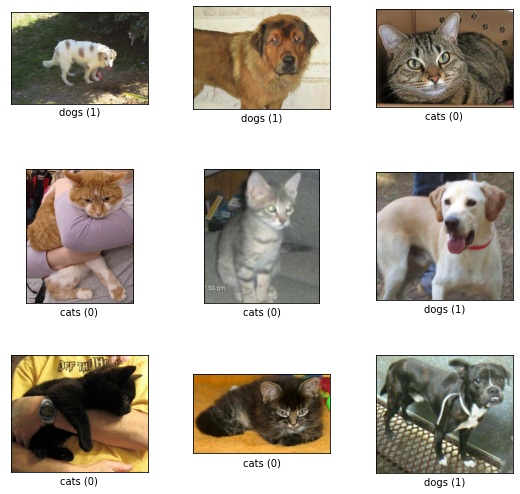

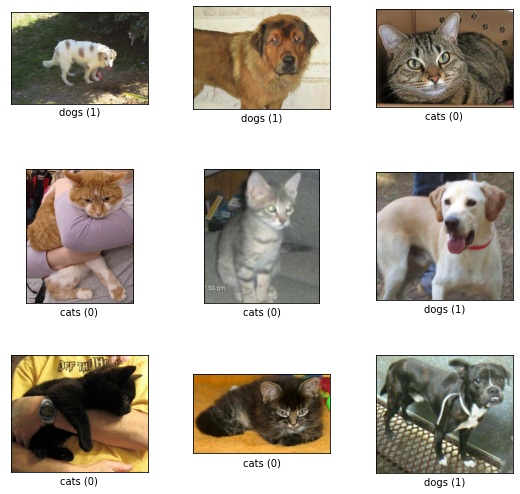

In [44]:
tfds.show_examples(train_ds, builder.info)  

In [53]:
IMG_SIZE = 224

In [54]:
def format_example(pair):
  print(pair['label'])
  image, label = pair['image'], pair['label']
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [55]:
train=train_ds.map(format_example)
valid=valid_ds.map(format_example)

Tensor("args_2:0", shape=(), dtype=int64)
Tensor("args_2:0", shape=(), dtype=int64)


In [41]:
train_ds

<_OptionsDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [56]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [57]:
train_batches = train.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_batches = valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_batches.take(1)

In [59]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape



TensorShape([32, 224, 224, 3])

In [68]:
print ('check types;' , type(ds)) 

check types; <class 'tensorflow.python.data.ops.dataset_ops._OptionsDataset'>


In [69]:
ds.element_spec

{'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}

In [70]:

                                                 )

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'image/filename': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>

In [20]:
ds.features['label'].num_classes

AttributeError: ignored